# Barren Plateaus

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In the training of classical neural networks, gradient-based optimization methods encounter the problem of local minimum and saddle points. Correspondingly, the Barren plateau phenomenon could potentially block us from efficiently training quantum neural networks. This peculiar phenomenon was first discovered by McClean et al. in 2018 [[1]](https://arxiv.org/abs/1803.11173). In a few words, when we randomly initialize the parameters in random circuit structure meets a certain degree of complexity, the optimization landscape will become very flat, which makes it difficult for the optimization method based on gradient descent to find the global minimum. For most variational quantum algorithms (VQE, etc.), this phenomenon means that when the number of qubits increases, randomly choosing a circuit ansatz and randomly initializing the parameters of it may not be a good idea. This will make the optimization landscape corresponding to the loss function into a huge plateau, which makes the training of QNN much more difficult. The initial random value for the optimization process is very likely to stay inside this plateau, and the convergence time of gradient descent will be prolonged.

![BP-fig-barren](./figures/BP-fig-barren.png)

The figure is generated through [Gradient Descent Viz](https://github.com/lilipads/gradient_descent_viz)

Based on the impact of gradient variation on the training of such variational quantum algorithms, we provide a gradient analysis tool module in the Paddle Quantum to assist users in diagnosing models and facilitate the study of problems such as barren plateaus.

This tutorial mainly discusses how to demonstrate the barren plateau phenomenon with Paddle Quantum and use the gradient analysis tool to analyze the parameter gradients in user-defined quantum neural networks. Although it does not involve any algorithmic innovation, it can help readers to understand the gradient-based training for QNN.

We first import the necessary libraries and packages:


In [1]:
# ignore waring 
import warnings
warnings.filterwarnings("ignore")

# Import packages needed
import time
import numpy as np
from math import pi
import paddle
from paddle_quantum.state import zero_state
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

# Drawing tools
from matplotlib import pyplot as plt 

c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult


## Random network structure

Here we follow the original method mentioned in the paper by McClean (2018) [[1]](https://arxiv.org/abs/1803.11173) and build the following random circuit:

![BP-fig-Barren_circuit](./figures/BP-fig-Barren_circuit.png)

First, we rotate all the qubits around the $y$-axis of the Bloch sphere with rotation gates $R_y(\pi/4)$.

The remaining structure is in form of blocks, each block can be further divided into two layers:

- The first layer is a set of random rotation gates on all the qubits, where $R_{\ell,n} \in \{R_x, R_y, R_z\}$. The subscript $\ell$ means the gate is in the $\ell$-th repeated block. In the figure above, $\ell =1$. The second subscript $n$ indicates which qubit it acts on.
- The second layer is composed of CZ gates, which act on adjacent qubits.

In Paddle Quantum, we can build this circuit with the following code:

In [2]:
def rand_circuit(target, num_qubits, theta=None):
    # Initialize the quantum circuit
    cir = Circuit(num_qubits)
    
    # Fixed-angle Ry rotation gates 
    cir.ry(param=pi / 4)

    # ============== First layer ==============
    # Fixed-angle Ry rotation gates 
    for i in range(num_qubits):
        if target[i] == 0:
            cir.rz(i, param=theta[i] if theta is not None else theta)
        elif target[i] == 1:
            cir.ry(i, param=theta[i] if theta is not None else theta)
        else:
            cir.rx(i, param=theta[i] if theta is not None else theta)
            
    # ============== Second layer ==============
    # Build adjacent CZ gates
    for i in range(num_qubits - 1):
        cir.cz([i, i + 1])
        
    return cir

## Loss function and optimization landscape

After determining the circuit structure, we also need to define a loss function to determine the optimization landscape. Following the same set up with McClean (2018)[[1]](https://arxiv.org/abs/1803.11173), we take the loss function from VQE:

$$
\mathcal{L}(\boldsymbol{\theta})= \langle0| U^{\dagger}(\boldsymbol{\theta})H U(\boldsymbol{\theta}) |0\rangle,
\tag{1}
$$

The unitary matrix $U(\boldsymbol{\theta})$ is the quantum neural network with the random structure that we build from the last section. For the Hamiltonian $H$, we also take the simplest form $H = |00\cdots 0\rangle\langle00\cdots 0|$. After that, we can start sampling gradients with the two-qubit case - generate 300 sets of random network structures and different random initial parameters $\{\theta_{\ell,n}^{( i)}\}_{i=1}^{300}$. Each time the partial derivative with respect to the **first parameter $\theta_{1,1}$** is calculated according to the analytical gradient formula from VQE. Then we analyze the mean and variance of these 300 sampled partial gradients. The formula for the analytical gradient is:

$$
\partial \theta_{j} 
\equiv \frac{\partial \mathcal{L}}{\partial \theta_j}
= \frac{1}{2} \big[\mathcal{L}(\theta_j + \frac{\pi}{2}) - \mathcal{L}(\theta_j - \frac{\pi}{2})\big].
\tag{2}
$$

For a detailed derivation, see [arXiv:1803.00745](https://arxiv.org/abs/1803.00745).


In [3]:
# Hyper parameter settings
# np.random.seed(42)   # Fixed Numpy random seed
N = 2                # Set the number of qubits
samples = 300        # Set the number of sampled random network structures
THETA_SIZE = N       # Set the size of the parameter theta
ITR = 1              # Set the number of iterations
LR = 0.2             # Set the learning rate
SEED = 1             # Fixed the randomly initialized seed in the optimizer

# Initialize the register for the gradient value
grad_info = []

# paddle.seed(SEED)
class manual_gradient(paddle.nn.Layer):
    
    # Initialize a list of learnable parameters and fill the initial value with a uniform distribution of [0, 2*pi]
    def __init__(self, shape, param_attr=paddle.nn.initializer.Uniform(low=0.0, high=2*pi), dtype='float32'):
        super(manual_gradient, self).__init__()
        
        # Convert Numpy array to Tensor in PaddlePaddle
        self.H = zero_state(N).data
        
    # Define loss function and forward propagation mechanism  
    def forward(self):
        
        # Initialize three theta parameter lists
        theta_np = np.random.uniform(low=0., high=2*pi, size=(THETA_SIZE))
        theta_plus_np = np.copy(theta_np) 
        theta_minus_np = np.copy(theta_np) 
        
        # Modified to calculate analytical gradient
        theta_plus_np[0] += np.pi/2
        theta_minus_np[0] -= np.pi/2
        
        # Convert Numpy array to Tensor in PaddlePaddle
        theta_plus = paddle.to_tensor(theta_plus_np)
        theta_minus = paddle.to_tensor(theta_minus_np)
        
        # Generate random targets, randomly select circuit gates in rand_circuit
        target = np.random.choice(3, N)      
        
        U_plus = rand_circuit(target, N, theta_plus).unitary_matrix()
        U_minus = rand_circuit(target, N, theta_minus).unitary_matrix()

        # Calculate the analytical gradient
        grad = paddle.real((dagger(U_plus) @ self.H @ U_plus)[0][0] - (dagger(U_minus) @ self.H @ U_minus)[0][0])/2  

        return grad

# Define the main block
def main():

    # Set the dimension of QNN
    sampling = manual_gradient(shape=[THETA_SIZE])
        
    # Sampling to obtain gradient information
    grad = sampling().numpy()
        
    return grad

# Record running time
time_start = time.time()

# Start sampling
for i in range(samples):
    if __name__ == '__main__':
        grad = main()
        grad_info.append(grad)

time_span = time.time() - time_start

print('The main program segment has run in total ', time_span, ' seconds')
print("Use ", samples, " samples to get the mean value of the gradient of the random network's first parameter, and we have：", np.mean(grad_info))
print("Use ", samples, "samples to get the variance of the gradient of the random network's first parameter, and we have：", np.var(grad_info))

c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


The main program segment has run in total  3.090050458908081  seconds
Use  300  samples to get the mean value of the gradient of the random network's first parameter, and we have： 0.016533764
Use  300 samples to get the variance of the gradient of the random network's first parameter, and we have： 0.09683221


## Visualization of the Optimization landscape

Next, we use Matplotlib to visualize the optimization landscape. In the case of **two qubits**, we only have two parameters $\theta_1$ and $\theta_2$, and there are 9 possibilities for the random circuit structure in the second layer. 

![BP-fig-landscape2](./figures/BP-fig-landscape2.png)

The plain structure shown in the $R_z$-$R_z$ layer from the last figure is something we should avoid. In this case, it's nearly impossible to converge to the theoretical minimum. If you want to try to draw some optimization landscapes yourself, please refer to the following code:

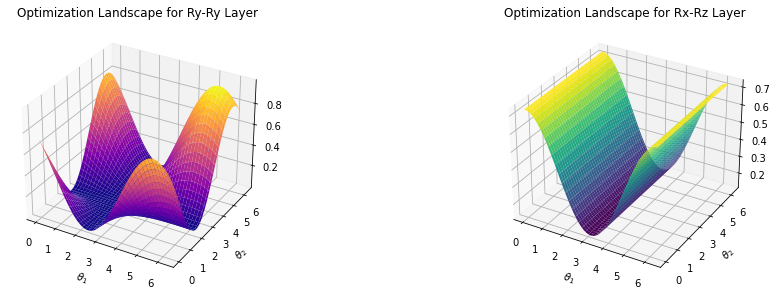

The main program segment has run in total  1.7086431980133057  seconds


In [4]:
time_start = time.time()
N = 2

# Set the image ratio Vertical: Horizontal = 0.3
fig = plt.figure(figsize=plt.figaspect(0.3))

# Generate points on the x, y axis
X = np.linspace(0, 2 * np.pi, 80)
Y = np.linspace(0, 2 * np.pi, 80)

# Generate 2D mesh
xx, yy = np.meshgrid(X, Y)


# Define the necessary logic gates
def rx(theta):
    mat = np.array([[np.cos(theta/2), -1j * np.sin(theta/2)],
                    [-1j * np.sin(theta/2), np.cos(theta/2)]])
    return mat

def ry(theta):
    mat = np.array([[np.cos(theta/2), -1 * np.sin(theta/2)],
                    [np.sin(theta/2), np.cos(theta/2)]])
    return mat

def rz(theta):
    mat = np.array([[np.exp(-1j * theta/2), 0],
                    [0, np.exp(1j * theta/2)]])
    return mat

def CZ():
    mat = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
    return mat

# ============= The first figure =============
# We visualize the case where the second layer is kron(Ry, Ry)
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Forward propagation to calculate loss function:
def cost_yy(para):
    L1 = np.kron(ry(np.pi/4), ry(np.pi/4))
    L2 = np.kron(ry(para[0]), ry(para[1]))
    U = np.matmul(np.matmul(L1, L2), CZ())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H@ U).real[0][0]
    return val

# Draw an image
Z = np.array([[cost_yy([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='plasma')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Ry Layer")

# ============= The second figure =============
# We visualize the case where the second layer is kron(Rx, Rz)
ax = fig.add_subplot(1, 2, 2, projection='3d')


def cost_xz(para):
    L1 = np.kron(ry(np.pi/4), ry(np.pi/4))
    L2 = np.kron(rx(para[0]), rz(para[1]))
    U = np.matmul(np.matmul(L1, L2), CZ())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H @ U).real[0][0]
    return val

Z = np.array([[cost_xz([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Rz Layer")


plt.show()

time_span = time.time() - time_start        
print('The main program segment has run in total ', time_span, ' seconds')

## Gradient Analysis Tool

Based on an important role that gradients play in phenomena such as barren plateaus, we developed a simple gradient analysis tool in Paddle Quantum to assist users in viewing gradients of each parameter in the circuit. This tool can be used to facilitate subsequent research on quantum neural networks.

Note that the users only need to define the **circuit** and **loss function** separately when using the gradient analysis tool, and there is no need to write their networks.


### Application I: Unsupervised Learning

For this case, we focus on variational quantum algorithms similar to the Variational Quantum Eigensolver (VQE). Suppose the objective function is the typical parameterized cost function used in VQA: $O(\theta) = \left\langle0\dots 0\right\lvert U^{\dagger}(\theta)HU(\theta) \left\lvert0\dots 0\right\rangle$，where $U(\theta)$ is a parameterized quantum circuit, $H$ is a Hamiltonian and $\theta = [\theta_1, \theta_2, \dots, \theta_n]$ is a list of trainable parameters in the circuit.

Here we use VQE to demonstrate the usage of this gradient analysis tool.



#### Paddle Quantum Implement

Firstly, import the packages needed for the problem.

In [5]:
# Import related modules from Paddle Quantum and PaddlePaddle
from paddle_quantum.qinfo import pauli_str_to_matrix, random_pauli_str_generator
from paddle_quantum.hamiltonian import Hamiltonian
# GradTool package
from paddle_quantum.gradtool import random_sample, show_gradient, plot_loss_grad, show_gradient

#### Define Quantum Circuits

Next, construct the parameterized quantum circuit $U(\theta)$ in the objective function. Here we still use the random circuit defined above.

#### Define Objective Function

Note here that in the gradient analysis module we call the function in the form of ``loss_func(circuit, *args)`` to calculate the objective function value. This means that the second argument is a variable argument, and the user is able to construct their own objective function form as needed.

In [6]:
# objective function
def loss_func(circuit: Circuit, H: Hamiltonian) -> paddle.Tensor:
    return circuit().expec_val(H, shots = 0)

Then set some parameters required for the application.

In [7]:
# Hyper parameter settings
#np.random.seed(1)   # Fixed Numpy random seed
N = 2                # Set the number of qubits
samples = 300        # Set the number of sampled random network structures
THETA_SIZE = N       # Set the size of the parameter theta
ITR = 120            # Set the number of iterations
LR = 0.1             # Set the learning rate
SEED = 1             # Fixed the randomly initialized seed in the optimizer

Randomly generate quantum circuits and a list of Hamiltonian information.

In [8]:
# paddle.seed(SEED)
target = np.random.choice(3, N)
# Random generate parameters between 0 and 2*Pi 
cir = rand_circuit(target, N)
print(cir)
# Random generate Hamiltonian information, in Pauli string format
H_l = Hamiltonian(random_pauli_str_generator(N, terms=7))
print('Hamiltonian info: ', H_l)

--Ry(0.785)----Rx(1.077)----*--
                            |  
--Ry(0.785)----Rz(0.623)----z--
                               
Hamiltonian info:  -0.6880109593275947 Z1
0.7323522915498704 Z0
-0.8871768419457995 Y0, Y1
-0.7724600283015672 X1
-0.39151551408092455 Y1
0.22370578944475894 Y0, Z1


``cir`` and ``H_l`` are the parameters needed for the objective function ``loss_func``.

Using the gradient analysis tool, we can get the results of the gradient sampling of each parameter in the circuit. There are three modes ``single``, ``max``, and ``random`` for users to choose, where ``single`` returns the mean and variance of each parameter after sampling the circuit multiple times, ``max`` mode returns the mean and variance of the maximum value of all parameter gradients in each round, and ``random`` calculates the mean and variance of random value of all parameter gradients in each round.

We sample the circuit 300 times, and here we choose the ``single`` mode to see the mean and variance of the gradient of each variable parameter in the circuit, while the default ``param=0`` means plot gradient distribution of the first parameter.



Sampling: 100%|###################################################| 300/300 [00:03<00:00, 77.68it/s]

Mean of gradient for all parameters: 
theta 1 :  0.015548194
theta 2 :  -0.026560133
Variance of gradient for all parameters: 
theta 1 :  0.20417707
theta 2 :  0.13769649


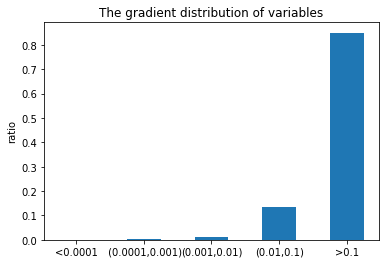

In [9]:
grad_mean_list, grad_variance_list = random_sample(cir, loss_func, samples, H_l, mode='single', param=0)

The user can also use the ``plot_loss_grad`` function to show the gradient and loss values variation during the training process.

Training:   0%|                                                             | 0/120 [00:00<?, ?it/s]c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype 

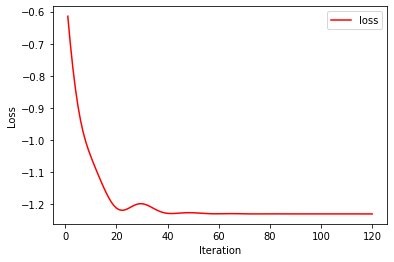

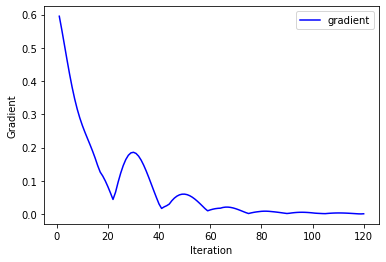

In [10]:
plot_loss_grad(cir, loss_func, ITR, LR, H_l)

As shown above, the loss value does not change after a few dozen times, and the gradient is very close to 0.
In order to see the difference between the optimal solution and the theoretical value clearly, we calculate the eigenvalues of the Hamiltonian ``H_l``.

In [11]:
loss, grad = show_gradient(cir, loss_func, ITR, LR, H_l)
H_matrix = H_l.construct_h_matrix()

print("optimal result: ", loss[-1])
print("real energy：", np.linalg.eigh(H_matrix)[0][0])

Training: 100%|###################################################| 120/120 [00:01<00:00, 87.80it/s]

optimal result:  -1.2294903
real energy： -2.064555


The comparison shows that there is still a gap between the optimal solution obtained from the training of this circuit and the actual value.

#### More qubits

Since in the barren plateau effect, the gradient disappears exponentially with increasing the number of quantum bits. Then, we will see what happens to the sampled gradients when we increase the number of qubits(here we sample by choosing ``max`` mode).

Sampling: 100%|###################################################| 300/300 [00:03<00:00, 75.81it/s]


Mean of max gradient
0.72318614
Variance of max gradient
0.0966615


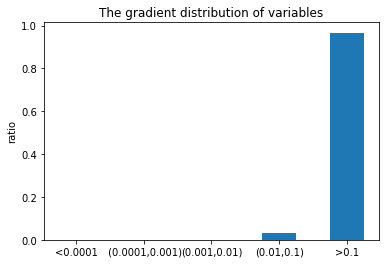

Sampling:   0%|                                                             | 0/300 [00:00<?, ?it/s]c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype 

Mean of max gradient
0.6837325
Variance of max gradient
0.0811426


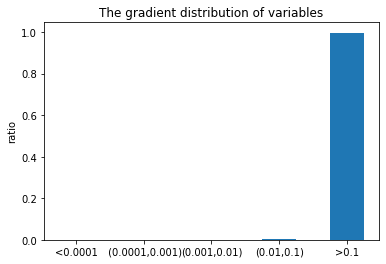

Sampling:   0%|                                                             | 0/300 [00:00<?, ?it/s]c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype 

Mean of max gradient
0.31329232
Variance of max gradient
0.01599442


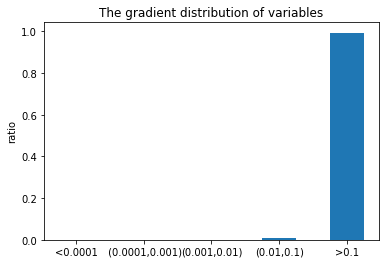

Sampling:   0%|                                                             | 0/300 [00:00<?, ?it/s]c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype 

Mean of max gradient
0.1499572
Variance of max gradient
0.0031638918


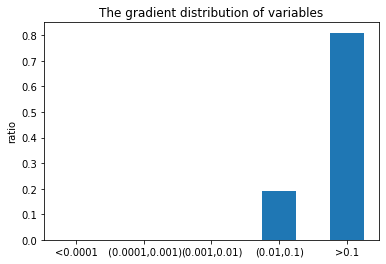

In [12]:
# Hyper parameter settings
selected_qubit = [2, 4, 6, 8]
means, variances = [], []

# Keep increasing the number of qubits
for N in selected_qubit:
    grad_info = []
    THETA_SIZE = N                
    target = np.random.choice(3, N)
    # Generate a value from 0 to 2PI
    cir = rand_circuit(target, N)
    
    H_l = Hamiltonian(random_pauli_str_generator(N, terms=10))
    
    grad_mean_list, grad_variance_list = random_sample(cir, loss_func, samples, H_l, mode='max')
    # Record sampling information
    means.append(grad_mean_list)
    variances.append(grad_variance_list)

To compare the mean and variance of the maximum gradient of each parameter, we plot them.

We then draw the statistical results of this sampled gradient:


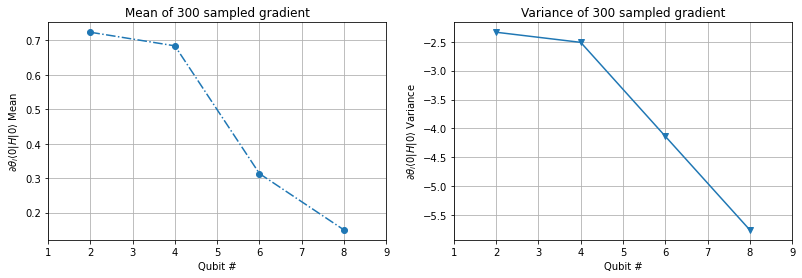

In [13]:
means = np.array(means)
variances = np.array(variances)

n = np.array(selected_qubit)
print("We then draw the statistical results of this sampled gradient:")
fig = plt.figure(figsize=plt.figaspect(0.3))

# ============= The first figure =============
# Calculate the relationship between the average gradient of random sampling and the number of qubits
plt.subplot(1, 2, 1)
plt.plot(n, means, "o-.")
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Mean")
plt.title("Mean of {} sampled gradient".format(samples))
plt.xlim([1,9])
plt.grid()

# ============= The second figure =============
# Calculate the relationship between the variance of the randomly sampled gradient and the number of qubits
plt.subplot(1, 2, 2)
plt.plot(n, np.log(variances), "v-")
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Variance")
plt.title("Variance of {} sampled gradient".format(samples))
plt.xlim([1,9])
plt.grid()

plt.show()

It can be seen that as the number of qubits increases, the maximum value of the gradient of all parameters obtained by multiple sampling is constantly close to 0, and the variance is also decreasing.

To further see how the gradient changes as the number of quantum bits increases, we might as well visualize the influence of choosing different qubits on the optimization landscape:

![BP-fig-qubit_landscape_compare](./figures/BP-fig-qubit_landscape_compare.png "(a) Optimization landscape sampled for 2,4,and 6 qubits from left to right in different z-axis scale. (b) Same landscape in a fixed z-axis scale.")

$\theta_1$ and $\theta_2$ are the first two circuit parameters, and the remaining parameters are all fixed to $\pi$. This way, it helps us visualize the shape of this high-dimensional manifold. Unsurprisingly, the landscape becomes more flatter as $n$ increases. **Notice the rapidly decreasing scale in the $z$-axis**. Compared with the 2-qubit case, the optimized landscape of 6 qubits is very flat.

Note that only when the network structure and loss function meet certain conditions, i.e. unitary 2-design (see paper [1]), this effect will appear.


### Application II: Quantum encoded classical data

Supervised learning is one of the important applications of quantum neural networks. However, the barren plateau phenomenon limits the performance of quantum variational algorithms in such problems. Therefore, how to design more efficient circuits and loss functions to avoid the barren plateau phenomenon is one of the important research directions of quantum neural networks at present.

In fact, it has been shown that using Renyi divergence as a loss function in the training of generative model can effectively avoid the barren plateau phenomenon [[3]](https://arxiv.org/abs/2106.09567). 
The gradient analysis tools allow us to quickly analyze the information related to the gradient in a supervised learning model, which can facilitate researchers to try to explore different quantum circuits and loss functions.

Here, we present an example using the dataset provided by [Encoding Classical Data into Quantum States](./tutorial/machine_learning/DataEncoding_EN.ipynb).

#### Paddle Quantum Implement

Firstly, import the packages needed for the problem.

In [14]:
from paddle_quantum.dataset import Iris
from paddle_quantum.gradtool import random_sample_supervised, plot_supervised_loss_grad

#### Define Quantum Circuits

Next, construct the parameterized quantum circuit $U(\theta)$.

In [15]:
def U_theta(n: int, depth: int):
    # Initialize the quantum circuit
    cir = Circuit(n)

    # rotation gates 
    cir.rz()
    cir.ry()
    cir.rz()

    # default depth = 1
    # Build adjacent CNOT gates and RY rotation gates 
    for _ in range(3, depth + 3):
        cir.cnot()
        cir.ry()
        
    return cir

#### Define Objective Function

Here the objective function ``loss_fun`` is defined, and the second parameter is still the variable ``*args``.

In [16]:
def loss_func(cir: Circuit, *args):
    # input the quantum states and training labels
    state_in = args[0]
    label = args[1]
    # Convert Numpy array to tensor
    label_pp = paddle.to_tensor(label).reshape([-1, 1])
    
    Utheta = cir.unitary_matrix()
    
    # Since Utheta is learned, we use row vector operations here to speed up the training without affecting the results
    state_out = state_in @ Utheta
    
    # Measure the expected value of the Pauli Z operator <Z>
    Ob = paddle.to_tensor(pauli_str_to_matrix([[1.0, 'z0']], qubit_num))
    E_Z = state_out @ Ob @ paddle.transpose(paddle.conj(state_out), perm=[0, 2, 1])

    # Mapping <Z> into label 
    state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5
    loss = paddle.mean((state_predict - label_pp) ** 2) # mean-squared error
    
    return loss
    

#### Define the dataset

Here, we use [Iris dataset](./tutorial/machine_learning/DataEncoding_EN.ipynb) to do the experiment.

In [17]:
time_start = time.time()

# Hyper parameter settings
test_rate = 0.2
qubit_num = 2 # Don't give too many qubits, otherwise it will be seriously overfitted
depth = 1
lr = 0.1
BATCH = 4
EPOCH = 4
SAMPLE = 300

# dataset
iris = Iris(encoding='amplitude_encoding', num_qubits=qubit_num, test_rate=test_rate, classes=[0,1], return_state=True)

# Get inputs and labels for the dataset
train_x, train_y = iris.train_x, iris.train_y  # train_x, test_x here is paddle.tensor type,  train_y，test_y here is ndarray type.
test_x, test_y = iris.test_x, iris.test_y
testing_data_num = len(test_y)
training_data_num = len(train_y)


# Creating trainable parameters for circuits
# Creating Circuits
circuit = U_theta(qubit_num, depth)

print(circuit)

--Rz(0.275)----Ry(1.589)----Rz(5.910)----*----x----Ry(0.235)--
                                         |    |               
--Rz(2.328)----Ry(2.518)----Rz(5.586)----x----*----Ry(2.902)--
                                                              


c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


Let's look at the variation of the loss function values and gradients during training with EPOCH=4 and BATCH=4.

c:\Users\jingmingrui\Anaconda3\envs\pd_dep\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


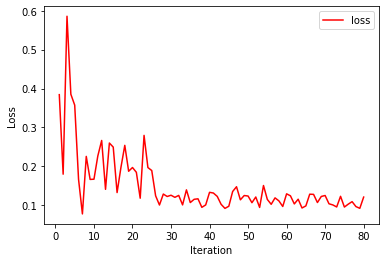

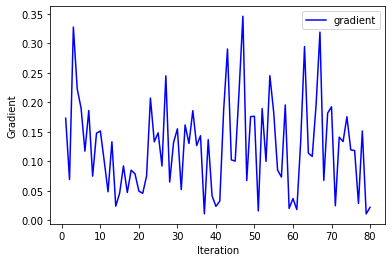

In [18]:
loss,grad = plot_supervised_loss_grad(circuit, loss_func, N=qubit_num, EPOCH=EPOCH, LR=lr,BATCH=BATCH, TRAIN_X=train_x, TRAIN_Y=train_y)

We can see that after ten steps of iteration, the value of the loss function only fluctuates in a small range, indicating that the training process is stable.

Then we randomly sample the initial parameters of the model 300 times, and here we choose the ``max`` mode to see the mean and variance of the maximum gradient for all parameters.

Sampling: 100%|###################################################| 300/300 [00:03<00:00, 92.32it/s]


Mean of max gradient
0.15071002
Variance of max gradient
0.0035270636


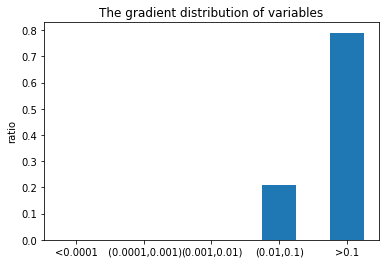

In [19]:
mean, variance = random_sample_supervised(circuit,loss_func, N=qubit_num, sample_num=SAMPLE, BATCH=BATCH, TRAIN_X=train_x, TRAIN_Y=train_y, mode='max')

## Summary

The trainability problem is a core direction of current research in quantum neural networks, and the gradient analysis tool provided by Quantum Paddle supports users to diagnose the trainability of the model, facilitating the study of subsequent problems such as barren plateaus.

_______

## References

[1] McClean, J. R., Boixo, S., Smelyanskiy, V. N., Babbush, R. & Neven, H. Barren plateaus in quantum neural network training landscapes. [Nat. Commun. 9, 4812 (2018).](https://www.nature.com/articles/s41467-018-07090-4)

[2] Cerezo, M., Sone, A., Volkoff, T., Cincio, L. & Coles, P. J. Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural Networks. [arXiv:2001.00550 (2020).](https://arxiv.org/abs/2001.00550)

[3] Kieferova, Maria, Ortiz Marrero Carlos, and Nathan Wiebe. "Quantum Generative Training Using R\'enyi Divergences." arXiv preprint [arXiv:2106.09567 (2021).](https://arxiv.org/abs/2106.09567)